## Test - Gaussian Turbulent Distribution imaged using Diffraction Refractometer

In [3]:
%load_ext autoreload
%autoreload 2

from diffractio import degrees, mm, plt, sp, um, np
from diffractio.scalar_fields_XY import Scalar_field_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.utils_optics import field_parameters


from sklearn.calibration import diagnosticResponse

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Parameters:
num_pixels = 201
length = 10 * mm
x0 = np.linspace(-length / 2, length / 2, num_pixels)
y0 = np.linspace(-length / 2, length / 2, num_pixels)
# Optical system
wavelength = 1.053 * um     # Laser Wavelength
L = 400 * mm                # this is 2*Focal Length, assumed based on the IRL setup

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'diagnosticResponse' from 'sklearn.calibration' (/home/administrator/Programs/anaconda3/envs/testing/lib/python3.12/site-packages/sklearn/calibration.py)

## Generate a turbulent medium

In [ ]:
sys.path.append("C:\\Users\\sm13118\\OneDrive - Imperial College London\\dev\\")
# sys.path.append("C:\\Users\\0xDuckie\\OneDrive - Imperial College London\\dev\\")

from MagPy.synthetic_tool.turboGen import gaussian3D_FFT
import MagPy.synthetic_tool.ABCD as abcd
import MagPy.synthetic_tool.particle_tracker as pt
from MagPy.synthetic_tool.PowerSpectrum import spectrum_3D_scalar, spectrum_2D_scalar, spectrum_1D_scalar

def power_spectrum(k,a):
    return k**-a

def k41_3D(k):
    return power_spectrum(k, 11/3)

In [ ]:
N_V = 100
M_V = 2*N_V+1
ne_extent = 5.0e-3
ne_x = np.linspace(-ne_extent,ne_extent,M_V)
ne_y = np.linspace(-ne_extent,ne_extent,M_V)
ne_z = np.linspace(-ne_extent,ne_extent,M_V)

gaussian = pt.ElectronCube(ne_x, ne_y, ne_z, ne_extent, B_on = False, inv_brems = False, phaseshift = False, probing_direction = 'z')

s3 = gaussian3D_FFT(N_V, k41_3D)
n_e0=1e24
dn_e=4e24
gaussian.ne = n_e0 + dn_e*s3/s3.std()

C:\Users\sm13118\AppData\Local\Temp\ipykernel_14932\2160444622.py:10: RuntimeWarning: divide by zero encountered in power
  return k**-a
C:\Users\sm13118\OneDrive - Imperial College London\dev\MagPy\synthetic_tool\turboGen.py:530: RuntimeWarning: invalid value encountered in multiply
  F = W*np.sqrt(k_func(K)) # power spectra follows power law, so sqrt here.


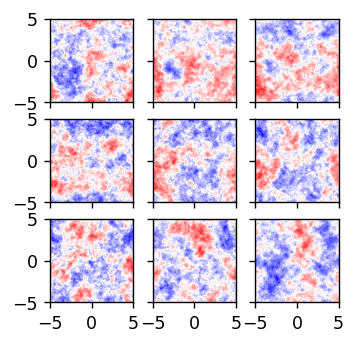

In [ ]:
## Pretty Plots
fig,ax=plt.subplots(3,3, figsize=(3,3), sharex=True, sharey=True)
ax=ax.flatten()
sc = 10/2
for i, a in enumerate(ax):
    r=(2*N_V+1)*i//9
    d=gaussian.ne[r,:,:]
    a.imshow(d, cmap='bwr', extent=[-sc,sc,-sc, sc])

## ray tracing through the plasma

In [ ]:
N_rays          =   int(1e5)

beam_size       =   5e-3        # 5 mm
divergence      =   0.05e-3     # 0.05 mrad, realistic

r =  gaussian
r.calc_dndr()
r.set_up_interps()

## Initialise rays and solve
s0 = pt.init_beam(Np = N_rays, beam_size = beam_size, divergence = divergence, ne_extent = ne_extent)
r.solve(s0)
rfgauss = r.rf

Incoherent
Ray trace completed in:	 226.27474427223206 s


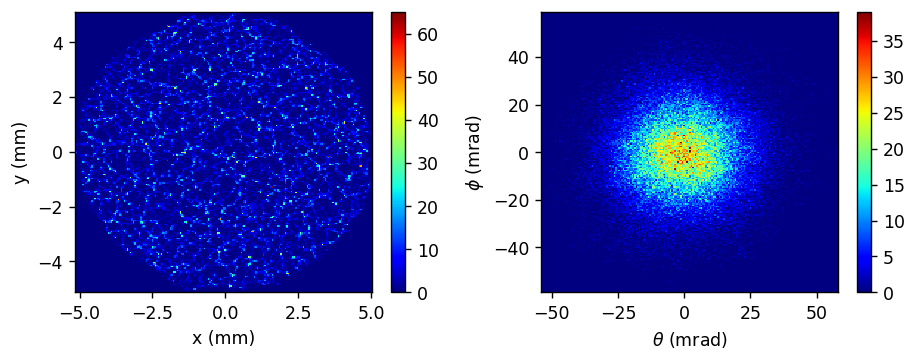

In [ ]:
## Plot ray location and angle at output to density cube
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5,3))
nbins = 201
_,_,_,im1 = ax1.hist2d(rfgauss[0]*1e3, rfgauss[2]*1e3, bins=(nbins, nbins), cmap=plt.cm.jet);
plt.colorbar(im1,ax=ax1)
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
_,_,_,im2 = ax2.hist2d(rfgauss[1]*1e3, rfgauss[3]*1e3, bins=(nbins, nbins), cmap=plt.cm.jet);
plt.colorbar(im2,ax=ax2)
ax2.set_xlabel(r"$\theta$ (mrad)")
ax2.set_ylabel(r"$\phi$ (mrad)")

fig.tight_layout()

In [ ]:
r.r0 = np.zeros((6, N_rays), dtype = 'complex')
r.r0[:4,:] = r.rf
r.r0[4:,:] = r.Jf
r.r0[0,:] *=1e3 #we use mm not m for the ray tracer
r.r0[2,:] *=1e3

In [ ]:
sn = abcd.Shadowgraphy(r.r0, L = 400, R = 25, focal_plane=5)
sn.solve()
sn.histogram(bin_scale = 10)

C:\Users\sm13118\OneDrive - Imperial College London\dev\MagPy\synthetic_tool\ABCD.py:105: RuntimeWarning: invalid value encountered in greater
  filt = rays[0,:]**2+rays[2,:]**2 > R**2


### Definition of the optical system

In [ ]:
# Define fields and relative optical elements
# num_pixels = 201
# length = 10 * mm
x0 = np.linspace(-length / 2, length / 2, 344)
y0 = np.linspace(-length / 2, length / 2, 257)

source  = Scalar_source_XY(x=x0, y=y0, wavelength=wavelength)        # Light source defined XY plane
l0      = Scalar_mask_XY(x=x0, y=y0, wavelength = wavelength)        # Lens 0 - first lens of the imaging refractomer diagnostic
t0      = Scalar_mask_XY(ne_x, ne_y, wavelength)
l1      = Scalar_mask_XY(x=x0, y=y0, wavelength = wavelength)            # lens 1 - second lens - hybrid lens  

source.gauss_beam(
    A=1,
    r0=(0 * um, 0 * um),
    z0=0 * mm,
    w0=(6.7 * mm, 6.7 * mm),
    phi= 0,
    theta= 0
)

l0.lens(
    r0=(0 * mm, 0 * mm),
    radius=(25 * mm, 25 * mm),
    focal=(L/2, L/2),
    angle=0 * degrees
)

# mask from ray tracer
x = np.linspace(ne_x[0], ne_x[-1], sn.H.shape[1])
y = np.linspace(ne_y[0], ne_y[-1], sn.H.shape[0])
X, Y = np.meshgrid(x, y)
t0.u = np.zeros_like(X)
t0.u = t0.u + sn.H
t0.u = 1 - t0.u

l1.lens(
    r0=(0 * mm, 0 * mm),
    radius=(25 * mm, 25 * mm),
    focal=(L/3, L/2),
    angle=0 * degrees
)

In [ ]:
# Beam Propagation through the system
# source --> l0 --> r0 --> l1 --> detector

u = source * t0                             # propagate beam through ronchi element
u1 = u.RS(z = L, new_field=True)            # propagate until l0
u2 = u1 * l0                                # propagate beam through lens 0
u3 = u2.RS(z = 3 * L / 2, new_field=True)   # propagate until l1
u4 = u3*l1                                  # propagate beam through lens 1
u5 = u4.RS(z = L, new_field=True)           # propagate until detector

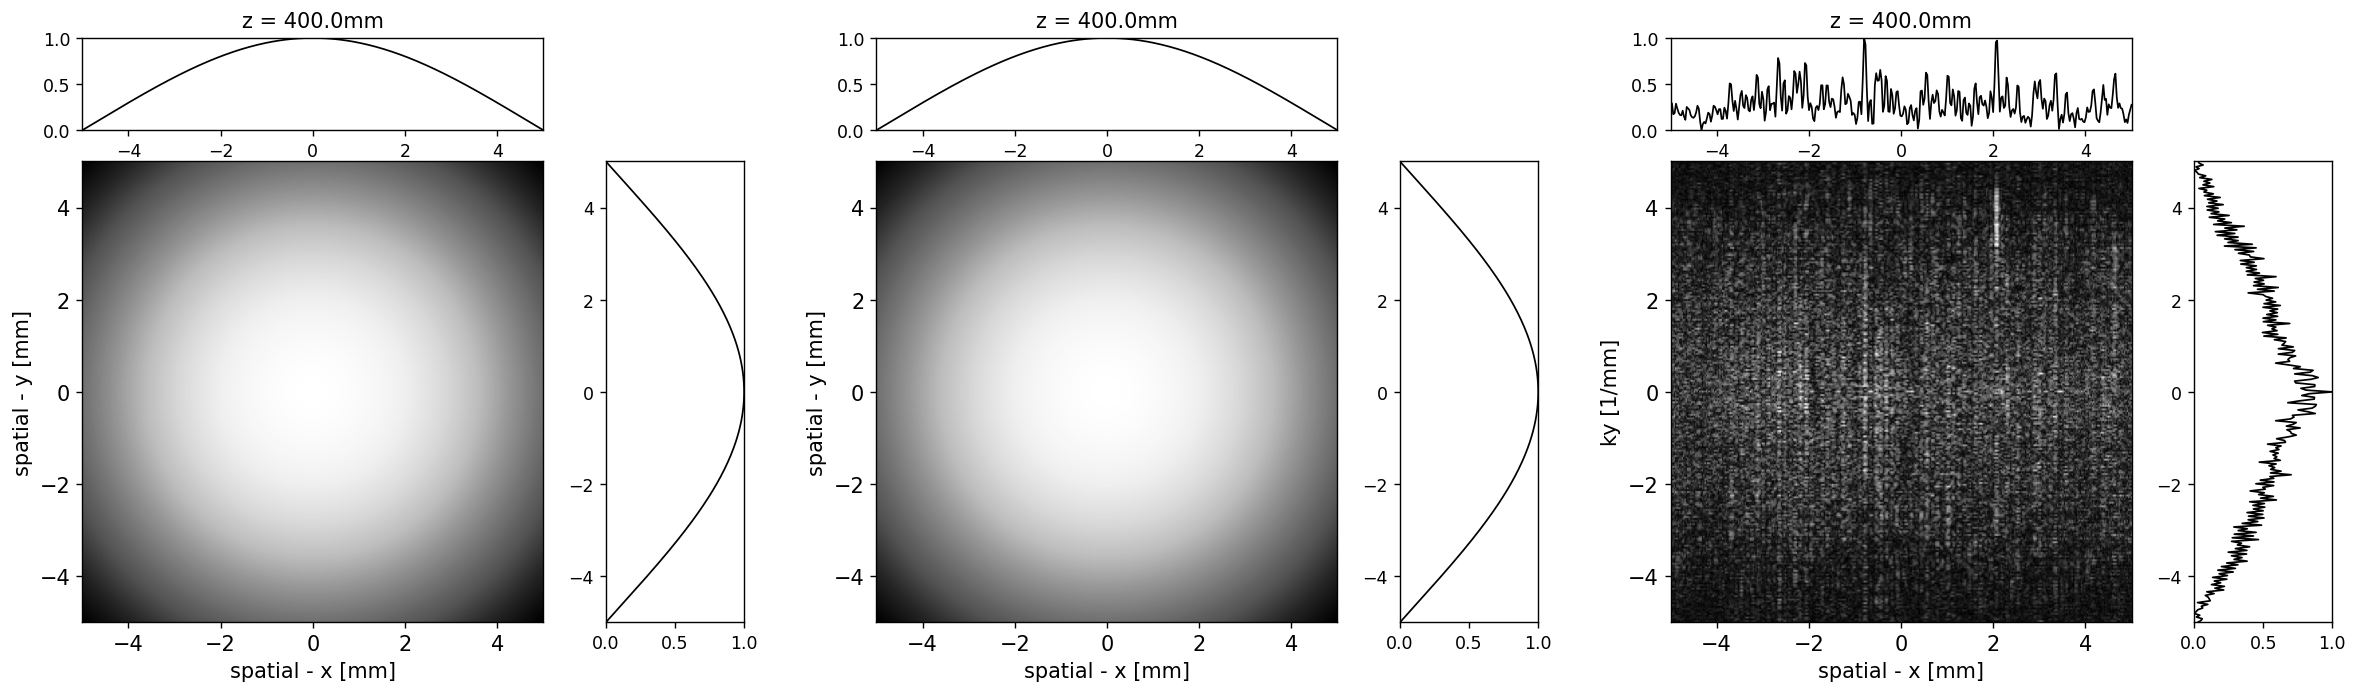

In [ ]:
response = diagnosticResponse(length, length, abs(source.u), abs(source.u), abs(u5.u), L)
response.plot(cmap = plt.cm.Greys_r)

In [ ]:
dx          =   2 * ne_extent / M_V
k_bin_num   =   100

f           =   abs(u5.u[100:200,100,200]).sum(1)
fsqr           =   np.real(f*np.conj(f))

#calculate k vectors in each dimension
Mx          =   len(f)
kx          =   np.fft.fftshift(np.fft.fftfreq(Mx, dx))
#calculate magnitude of k at each grid point
K           =   np.sqrt(kx**2)
#determine 1D spectrum of k, measured from origin
# #sort array in ascending k, and sort power by the same factor

K_flat          =   K.flatten()
fsqr_flat       =   fsqr.flatten()
K_sort          =   K_flat[K_flat.argsort()]
fsqr_sort       =   fsqr_flat[K_flat.argsort()]
k_bin_width     =   K_sort.max()/k_bin_num

k_bins          =   k_bin_width*np.arange(0,k_bin_num+1)
k_bins_weighted =   0.5*(k_bins[:-1]+k_bins[1:])
   
spect1D         =   np.zeros_like(k_bins_weighted)

for i in range(1,k_bin_num):
    upper        =   K_sort<i*k_bin_width # find only values below upper bound: BOOL
    lower        =   K_sort>=(i-1)*k_bin_width #find only values above upper bound: BOOL
    f_filtered   =   fsqr_sort[upper*lower] # use super numpy array filtering to select only those which match both!
    spect1D[i-1] =   f_filtered.mean() #and take their mean.

k_bins_weighted_g, spect3D_g = spectrum_3D_scalar(gaussian.ne, dx, k_bin_num=k_bin_num)

NameError: name 'ne_extent' is not defined

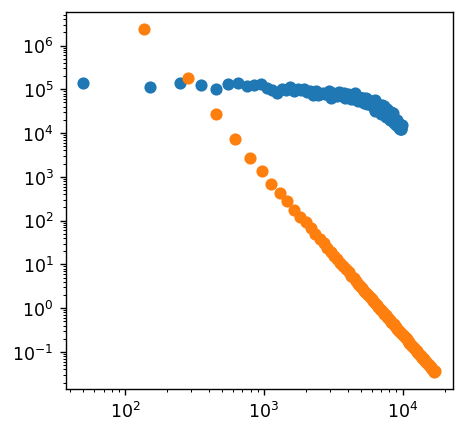

In [ ]:
fig,ax=plt.subplots()
ax.scatter(k_bins_weighted,spect1D)
ax.scatter(k_bins_weighted_g, 1e-55*spect3D_g)

ax.set_xscale('log')
ax.set_yscale('log')